In [2]:
import numpy as np
import pandas as pd
import iminuit
import sys
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from scipy.integrate import quad

from scipy import stats
from scipy.stats import cauchy as lorentz
from scipy.special import voigt_profile as voigt
from scipy.special import erf, erfc

## 0. raw data for traces
Cases below should be throw:  

Sensor events: sharp peak with rapid drop, caused by interactions directly in the paramagnetic sensor (instead of the absorber)

Pile-up events: trace on top of a trace, two interactions shortly after another, before the temperature could return to the equilibrium

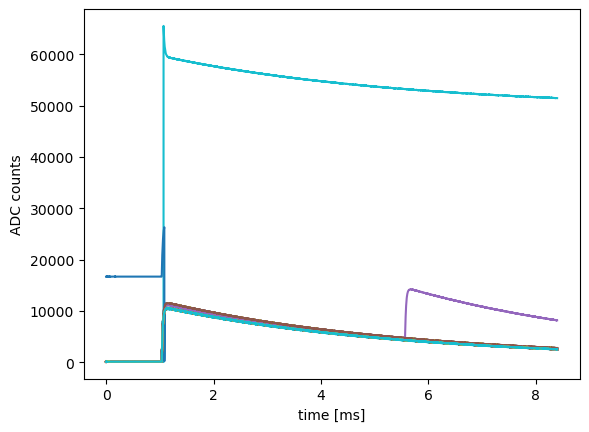

In [3]:
traces = pd.read_csv('traces.csv.gz', header=None)

fig, ax = plt.subplots()
for j in range(100):
    plt.plot([i/32768*8.4 for i in range(len(traces.iloc[j]))], traces.iloc[j])
plt.xlabel(r"time [ms]")
plt.ylabel("ADC counts")
plt.show()

### Why Voigt?
- In X-ray spectroscopy, the theoretical "natural line shape" is Lorentzian (due to the finite lifetime of atomic states).
Real detectors and Doppler broadening introduce additional Gaussian-like broadening.  
- Hence, convolving Lorentzian and Gaussian gives a Voigt profile, a more realistic model of the observed line shape.

### Why `erfc`?
- Some fraction of the energy (phonons) can escape the detector before being fully measured, causing a tail on the low-energy side. Multiplying by `erfc` captures this tail suppression.


## 1. Baseline offset cut
First cut been applied on the entry baseline offset. A larger offset often indicates the detector was not at the stable reference temperature at the time of the event.

In [5]:
#preselection: set a cut on baseline offset
mask_baseline_offset = (df['baseline_offset'] > 129) & (df['baseline_offset'] < 133)
mask_sel = mask_baseline_offset

## 2. Time Correction (“Drift Correction”)

Over the **50-minute** run, the amplitude of pulses (“OF amplitudes”) drifts (likely from a slow temperature or electronics change).

### Binning, Mean Calculation, and Polynomial Fit
1. **Bin in time**: use `stats.binned_statistic` to split events into time bins and compute the mean OF amplitude in each bin.  
2. **Fit a linear function** (first-order polynomial) to that mean amplitude vs. time.  
3. **Correct each event** by
   $$
   A_{\text{cOF}} \;=\; A_{\text{original}} \;\times\; \frac{\mu_{\text{overall}}}{A_{\text{fit}}(t)}
   $$
   where 
   - $A_{\text{original}}$ is the measured amplitude,  
   - $A_{\text{fit}}(t)$ is the fitted amplitude at the event’s time, and  
   - $\mu_{\text{overall}}$ is the average amplitude across the time bins.

### Why do we do this?
- We want all events to be on a consistent amplitude scale, as if no drift had occurred.

---

## 5. Combining Corrected Amplitudes

We have **two optimum filters**:
- \(\text{OF}_\alpha\) (optimized for K\(\alpha\))  
- \(\text{OF}_\beta\) (optimized for K\(\beta\))

After time-correcting both, the code:
- Uses `cOF_ampl_0` (K\(\alpha\)) for events near the K\(\alpha\) peak region.  
- Uses `cOF_ampl_1` (K\(\beta\)) for events near the K\(\beta\) peak.  
- Combines into one column `df['cOF_ampl']` for further fitting.

---

## 6. Energy Calibration

We want to relate the corrected OF amplitude $A_{\text{cOF}}$ to the true X-ray energy $E$.

1. **Parametric Model**  
   A quadratic calibration:
   $$
   E \;=\; p_1 \, A_{\text{cOF}}^2 \;+\; p_2 \, A_{\text{cOF}}
   $$
   In the code, these are `E_2`, `E_1`, `E_0`.

2. **Binned $\chi^2$ Fit**  
   - We take the distribution of `cOF_ampl` near the K$\alpha$ line, convert it to energy with our guessed parameters, and compare to the theoretical Voigt + tail model.  
   - The code calculates a $\chi^2$ between **observed** and **model** histograms.  
   - `iminuit` optimizes parameters ($\sigma_0, \text{esc}_k,\dots$) to minimize $\chi^2$.

---

## 7. Extracting Detector Resolution

From the fit, $\sigma_0$ is the Gaussian width (in eV). The **Full-Width at Half Maximum** (FWHM) for a Gaussian is
$$
\mathrm{FWHM} \;=\; 2 \,\sqrt{2\,\ln(2)}\;\sigma.
$$
Example:
```python
fwhm = m.values['sigma_0'] * 2 * np.sqrt(2 * np.log(2))
fwhm_err = m.errors['sigma_0'] * 2 * np.sqrt(2 * np.log(2))
print(f'FWHM: ({fwhm:.3f} +- {fwhm_err:.3f}) eV')

## 8. Reduced \(\chi^2\) and Fit Quality

- The total \(\chi^2\) value is stored in `m.fval`.
- The **degrees of freedom** (\(\mathrm{ndof}\)) is usually computed as:
  
  $$
  \mathrm{ndof} = N_{\text{bins}} \;-\; 1 \;-\; N_{\text{parameters}}.
  $$
  
- The **reduced** \(\chi^2\), often written \(\chi^2_\nu\), is:
  
  $$
  \chi^2_\nu \;=\; \frac{\chi^2}{\mathrm{ndof}}.
  $$
  
- As a rule of thumb:
  - If \(\chi^2_\nu \approx 1\), the fit is reasonable.
  - If \(\chi^2_\nu \gg 1\), the model may be inadequate or errors are underestimated.
  - If \(\chi^2_\nu \ll 1\), the errors might be overestimated or the model is overfitting.

### Example in Code

```python
alpha_chi2 = m.fval
alpha_ndof = alpha_bins[-1] - 1 - 5
alpha_reduced_chi2 = alpha_chi2 / alpha_ndof

beta_chi2 = mb.fval
beta_ndof = 41 - 1 - 5
beta_reduced_chi2 = beta_chi2 / beta_ndof
